## Purpose:

Stack the rasters for each grid and calculate the standard deviation for each pixel.

In [ ]:
!pip install pandarallel --user

In [122]:
import matplotlib.pyplot as plt
import mplleaflet
import rasterio as rio
import rasterio.warp
import pyproj
import pandas as pd
import numpy as np
import glob
import os

# from pandarallel import pandarallel

In [4]:
index = pd.read_pickle('../../data/rasters.pkl')
print('Loaded', len(index), 'rasters')

Loaded 378 rasters


In [5]:
grids = pd.read_pickle('../../data/grid_data.pkl')
print('Loaded', len(grids), 'grids')

Loaded 1263 grids


#### Function to stack all of a grid's rasters.

Creates a numpy array of shape: (num_rasters, 501, 501)

Sorted temporally so that **stack[-1,:,:]** is the most recent image.

In [6]:
def stack_rasters(grid, max_nodata=None):
    '''
    Stacks the grid's rasters into one numpy array
    DIMENSIONS:
    0: time
    1: x
    2: y
    '''
    rasters = glob.glob('../../data/grids/' + str(grid.name) + '/*v3.0_dem.tif')  # grab all rasters
    rasters.sort(key=lambda x: x.split('_')[2])  # sort the rasters by date acquired


    arrays = []
    for raster in rasters:
        dem = rio.open(raster).read(1) # Open Data        
        mask = rio.open(raster).read_masks(1).astype(float)  # Open Mask
        if dem.shape != (501,501):
            print(raster)
            return

        # Calculate Amount of No Data (100 means no data at all)
        _, counts = np.unique(mask, return_counts=True)
        mask[mask==0] = np.nan
        nodata_val = counts[0] / (counts[0] + counts[1]) * 100
        
        # Apply Laser Altimetry Correction
        raster_name = raster[raster.rfind('/')+1:raster.rfind('_')]
        dem = dem + index.loc[raster_name]['dz']
        dem = dem * mask / 255  # Mask the Data (no data becomes nan)
        
        if max_nodata:
            if nodata_val < max_nodata:
                arrays.append(dem)

        else:
            arrays.append(dem)
    
    stack = np.stack(arrays, axis=0)
    return stack

#### Function to calculate the standard deviation raster of a grid

Pixel-level standard deviation used to identify bodies of water

In [7]:
def std_raster(grid, custom_outfile=None):
    out_dir = '../../data/standard_deviation_with_corner_check/'
    outfile = out_dir + str(grid.name) + '.tif'
    
    if custom_outfile:
        outfile = custom_outfile
        
    if os.path.exists(outfile):
        return
    
    stack = stack_rasters(grid, max_nodata=90)  # Stack the rasters with a nodata threshold of 90% 
    stack = np.stack([raster for raster in stack if not nan_corners(raster, max_nan_corners=1)])  # Check the corners of the raster for nan values, threshold is 1
    stack = np.nan_to_num(stack)  # Convert nan values to 0
    
    std = stack.std(axis=0)  # Calculate standard deviation
    rasters = glob.glob('../../data/grids/' + str(grid.name) + '/*v3.0_dem.tif')
    metadata = rio.open(rasters[0]).meta  # Get Metadata
    metadata.update({'dtype':'float64'})  # Update raster datatype to float64
            
    with rio.open(outfile, 'w', **metadata) as dst:
        dst.write(std, 1)
    return

#### Function to check the corners of each raster for nan values

In [8]:
def nan_corners(raster, max_nan_corners=0):
    max_x = raster.shape[0]-2
    max_y = raster.shape[1]-2
      
    count = int(np.isnan(raster[0,0])) + \
            int(np.isnan(raster[0, max_y])) + \
            int(np.isnan(raster[max_x, 0])) + \
            int(np.isnan(raster[max_x, max_y]))
    
    return count > max_nan_corners

## Standard Deviation Raster Investigation

In [10]:
one_corner_dir = '../../data/standard_deviation_with_corner_check/'
zero_corner_dir = '../../data/standard_deviation_0_corners/'

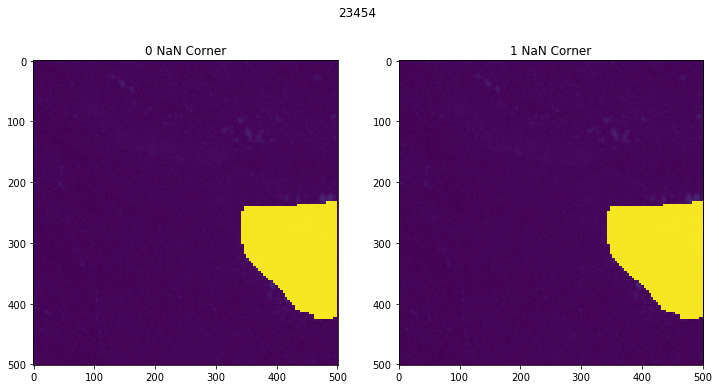

In [171]:
grid = str(np.random.choice(grids.index))
one = one_corner_dir + grid + '.tif' 
zero = zero_corner_dir + grid + '.tif'

# # Get extent of raster for Google Maps tile
# src = rio.open(one)
# src_proj = pyproj.Proj(init='epsg:3413')
# dst_proj = pyproj.Proj(init='epsg:4326')

# extent = rio.transform.array_bounds(501,501,src.meta['transform'])

# # Convert to lat lon
# xmin, ymin = pyproj.transform(src_proj, dst_proj, extent[0], extent[1])
# xmax, ymax = pyproj.transform(src_proj, dst_proj, extent[2], extent[3])


fig, ax = plt.subplots(1,2, figsize=(12,6))
fig.suptitle(grid)
ax[0].imshow(rio.open(zero).read(1))
ax[0].set_title('0 NaN Corner')

ax[1].imshow(rio.open(one).read(1))
ax[1].set_title('1 NaN Corner')

plt.show()